# Classical/Frequentist Statistical Inference: I

*J. H. Hazboun (2024)*

Material in this lecture and notebook is based upon the "Maximum Likelihood and Applications in Astronomy" lectures of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18). Also the "Inference" lectures of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 


***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Contents
* [Statistical Inference](#one)
* [Maximum Likelihood Estimation](#two)
* [MLE Applied To A Homoscedastic Gaussian](#three)
* [Quantifying Estimate Uncertainty](#four)
* [MLE Applied To A Heteroscedastic Gaussian](#five)
* [Working With non-Gaussian Likelihoods](#six)
---

## Statistical Inference <a class="anchor" id="one"></a>

Statistical *inference* is about drawing conclusions from data, specifically determining the properties of a population by data sampling.

Three examples of inference are:
1. What is the best estimate for a model parameter?
2. How confident are we about our result?
3. Are the data consistent with a particular model/hypothesis?

### Some Terminology

* We typically study the properties of some ***population*** by measuring ***samples*** from that population. The population doesn't have to refer to different objects. E.g., we may be (re)measuring the position of an object at rest; the population is the distribution of (an infinite number of) measurements smeared by the uncertainty, and the sample are the measurement we've actually taken.


* A ***statistic*** is any function of the sample. For example, the sample mean is a statistic. But also, "the value of the first measurement" is also a statistic. Don't stress too much about how to make a statistic; it's just a way of summarizing data in a way that helps reveal the presence of a signal. We will meet ways of finding the optimal statistic for a given scenario.


* To conclude something about the population from the sample, we develop ***estimators***. An estimator is a statistic, a rule for calculating an estimate of a given quantity based on observed data.


* There are ***point*** and ***interval estimators***. The point estimators yield single-valued results (example: the position of an object), while with an interval estimator, the result would be a range of plausible values (example: confidence interval for the position of an object).


* Measurements have **uncertainties** (not errors) and we need to account for these (sometimes they are unknown). Data are not variables but fixed values.

### Frequentist vs. Bayesian Inference

There are two major statistical paradigms that address the statistical inference questions: 
- the **classical**, or **frequentist** paradigm,
- the **Bayesian** paradigm.

While most of statistics and machine learning is based on the classical paradigm, Bayesian techniques are being embraced by the statistical and scientific communities at an ever-increasing pace...especially in astrophysics.

#### Key differences
- **Definition of probabilities**:
    - In ***frequentist inference***, probabilities describe the ***relative frequency of events*** over repeated experimental trials. 
    - In ***Bayesian infernece***, probabilities instead quantify our ***subjective belief about experimental outcomes, model parameters, or even models themselves***. 
    
    
- **Quantifying uncertainty**:
    - In ***frequentist inference*** we have ***confidence levels*** that describe the distribution of the measured parameter from the data around the true value.
    - In ***Bayesian inference*** we have ***credible regions*** derived from posterior probabilitiy distributions (we'll meet these later). These encode our "***belief spread***" in model parameters. 

#### Example
Let's say that you get the results of an IQ test.  Any given test result might not give you your "real" IQ (whatever that means anyway...).  But it gives us a way to *estimate* it (and the possible range of values).  
- For a frequentist, the best estimator is the average of many test results.  So, if you took 5 IQ tests and got a sample mean of 160, then that would be the estimator of your true IQ.
- On the other hand, a Bayesian would say: "*but wait, I know that IQ tests are calibrated to have a mean of 100 with a standard deviation of 15 points*".  So they will use that as "prior" information, which is important here since 160 is a 4$\sigma$ outlier. 

There's nothing mysterious about priors. It simply encodes any previous knowledge or information we have about our experiment.

The following article provides a nice example that is visualized below (without the detailed math) [Efron 1978](http://www.jstor.org/stable/2321163?seq=1#page_scan_tab_contents)

In [18]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=10, usetex=True)

<font color='red'>Complete and execute the following cell. It will show the simple average of IQ tests, the prior distribution one would use in a Bayesian analysis, and the final Bayesian posterior "belief" distribution.</font>

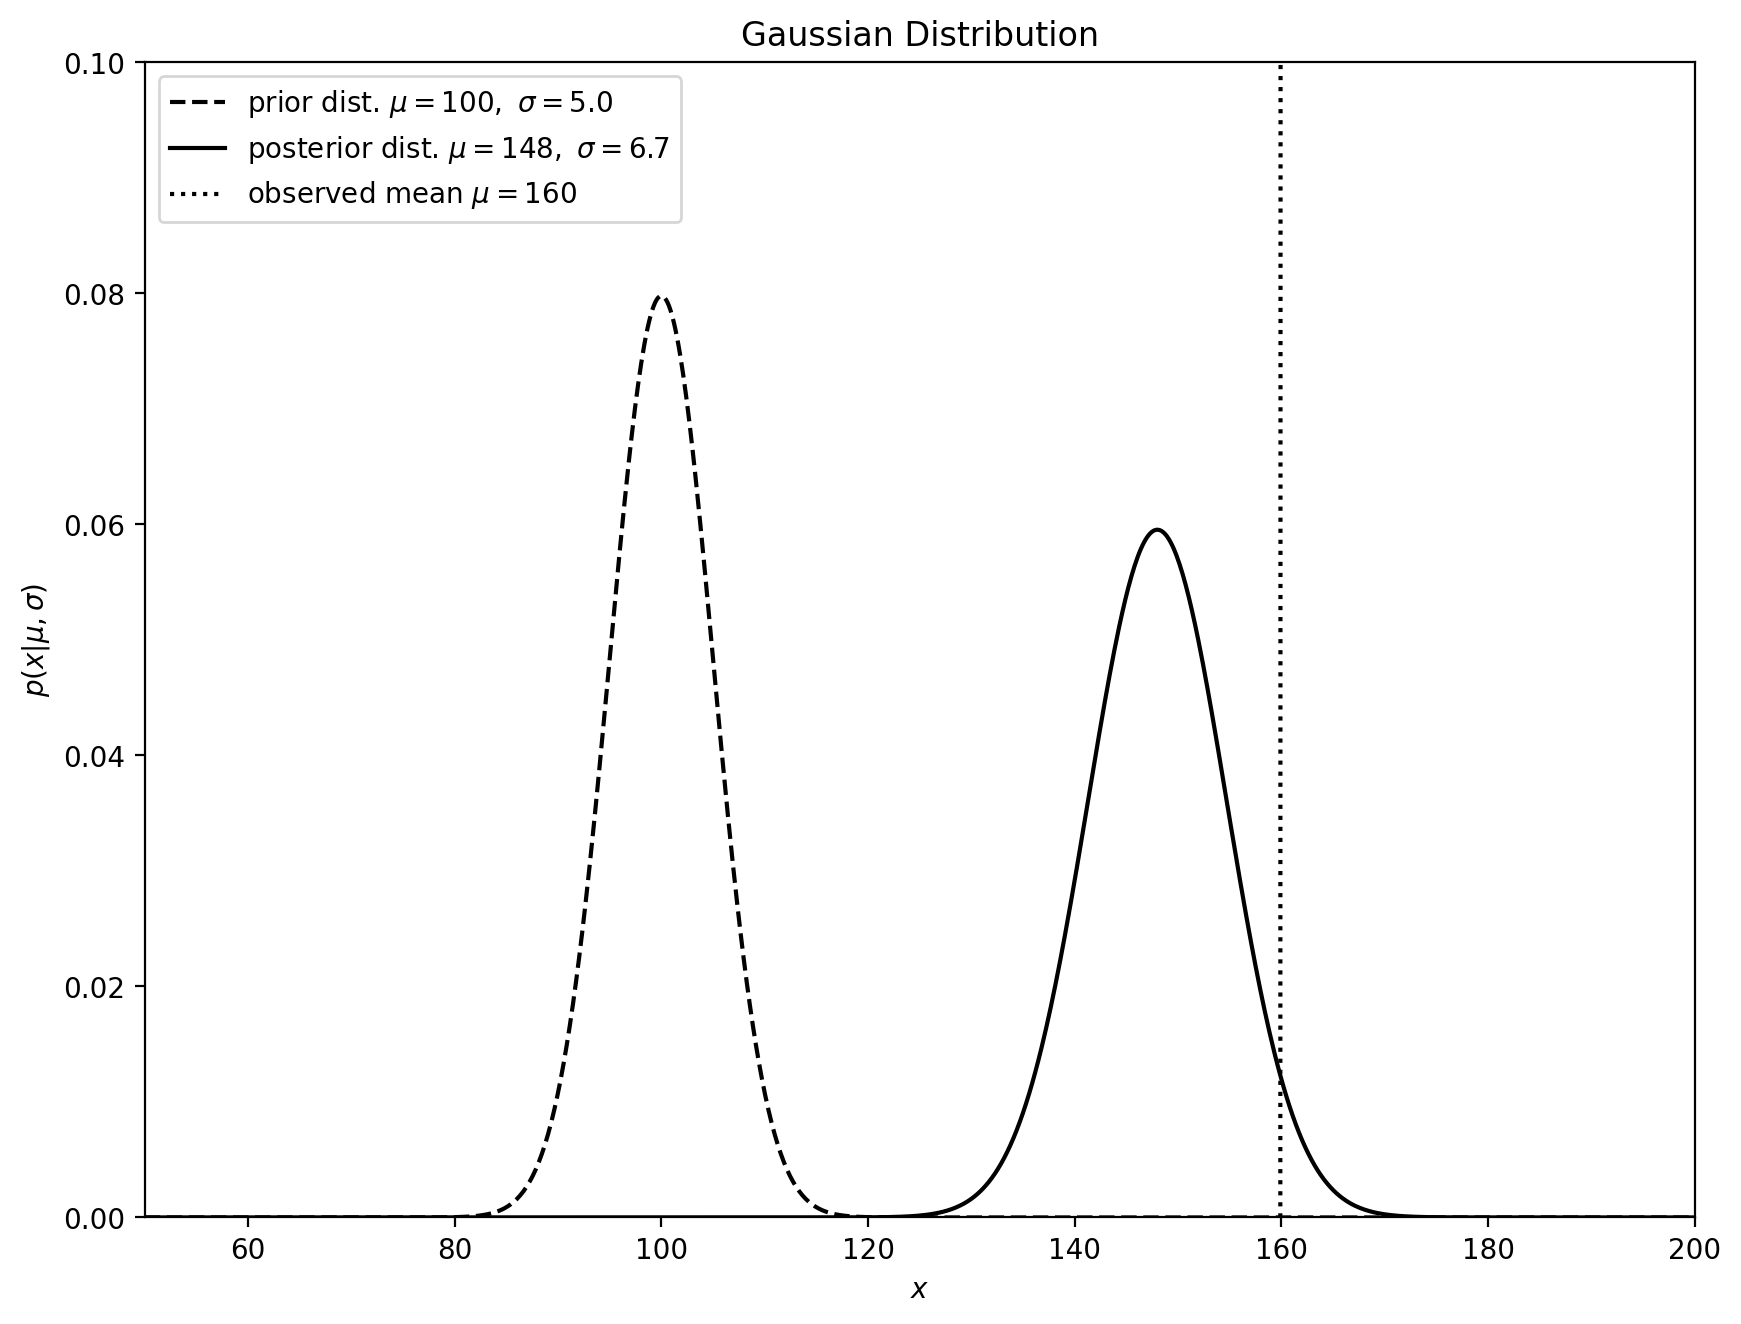

In [19]:
#------------------------------------------------------------
# Define the distributions to be plotted
sigma_values = [5, 6.7, 1] #complete with the prior width of IQ distribution
linestyles = ['--', '-', ':']
mu_values = [100, 148, 160] #complete with the prior mean of IQ distribution
labeltext = ['prior dist.', 
             'posterior dist.', 
             'observed mean']
xplot = np.linspace(50, 200, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))

for sigma, ls, mu, lab in zip(sigma_values, 
                              linestyles, 
                              mu_values, 
                              labeltext):
    
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    if sigma > 1:
        plt.plot(xplot, dist.pdf(xplot), 
                 ls=ls, c='black',
                 label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9, 160.1], [0, 0.8], 
                 ls=ls, color='k', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()

The end result (skipping over the detailed math) is that the Bayesian estimate of the IQ is not 160, but rather 148, or more specifically that $p(141.3\le \mu \le 154.7 \, | \, \overline{x}=160) = 0.683$. This estimate incorporates the prior information of how the IQ distribution is calibrated. We also saw in *Lecture 2* the huge influence that priors can have.

This all seems totally fine; where's the controvery with Bayesian methods? The controvery arises when we don't know the prior distribution, or when the parameter is fixed but we are trying to experimentally verify it (e.g., the speed of light). We'll return to this.

## Maximum Likelihood Estimation (MLE) <a class="anchor" id="two"></a>

Let's talk about maximum likelihood estimation ($\S 4.2$ in the textbook), which is relevant to both Bayesian and Frequentist approaches.

### Maximum Likelihood Approach

Maximum likelihood estimation follows this blueprint:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, the data are a measurement of some quantity with Gaussian random uncertainties (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.


2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta^0}$.


3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta^0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation (we'll come to these later).


4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

### Example: Measuring the Position of a Quasar

Let's assume we wish to estimate the position $x$ of a quasar from a series of individual astrometric measurements.

1. We adopt a model where the observed quasar does not move, and has individual measurement uncertainties 
2. We derive the expression for the likelihood of there being a quasar at position $x_0$ that gives rise to our individual measurements. We find the value of $\hat x_0$ for which our observations are maximally likely.
3. We determine the uncertainties (confidence intervals) on our measurement.
4. We test whether what we've observed is consistent with our adopted model. For example, is it possible that the quasar was really a misidentified star with measurable proper motion?

Note: in the text to come, I will use $\mu$ instead of $x_0$ to denote the true position of the quasar. This is to avoid potential confusion with the first (or zeroth) measurement of $x$.

<font color='red'>Stop here for a minute and talk with your colleagues. What likelihood function would you choose as an approximation for this situation? What underlying assumptions did you make?</font>

In [20]:
#Maybe gaussian distribution? we need position so gaussian peak will help us to find it more accurately.
#randomly choosing individual measurement will still give somewhere near the actual range.

### The Likelihood Function

If we know the distribution from which our data were drawn (or make a hypothesis about it), then we can compute the **probability** of our data being generated.

For example, if our data are generated by a Gaussian process with mean $\mu$ and standard deviation $\sigma$, then the probability density of a certain value $x$ is

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

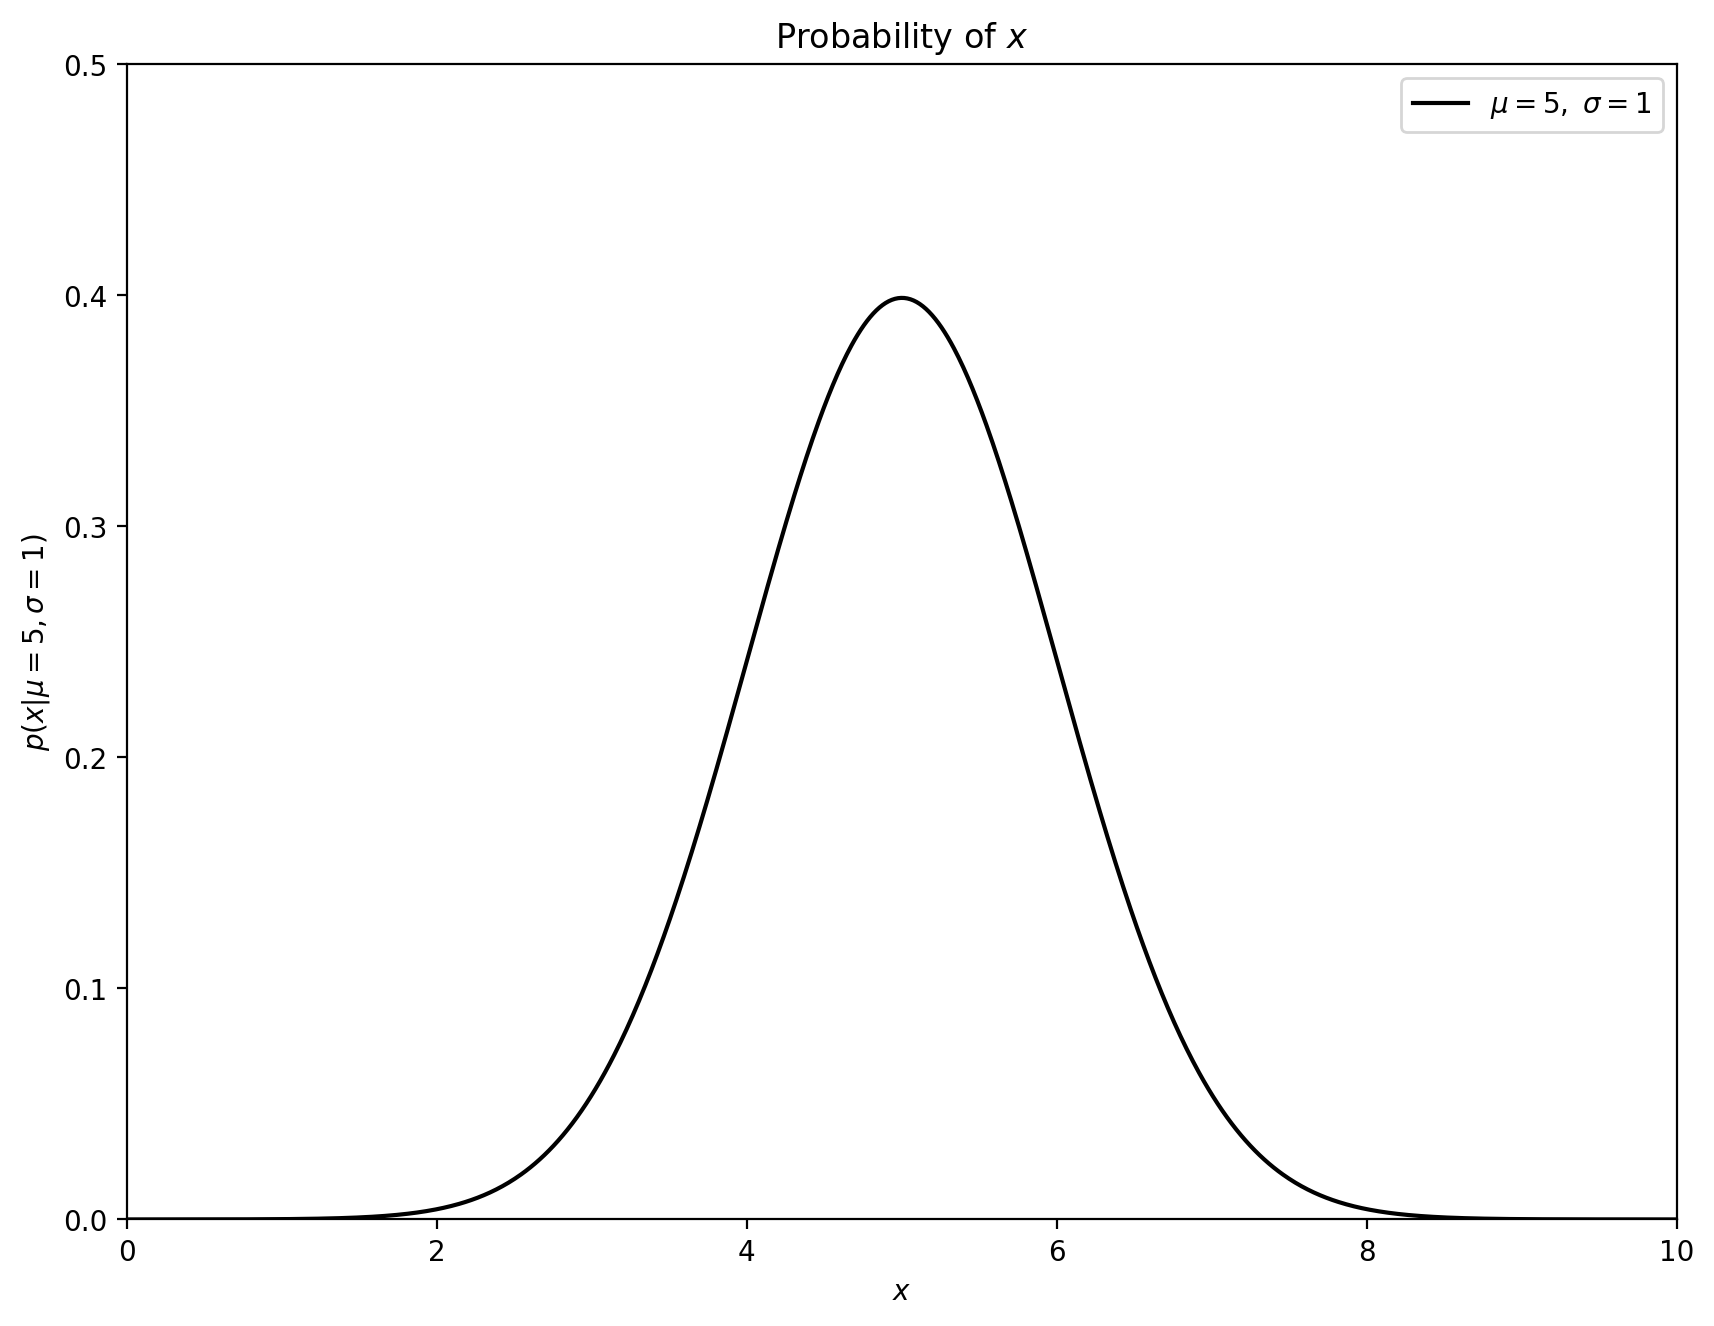

In [21]:
# Execute this cell
#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))
dist = norm(5, 1)
x = np.linspace(0, 10, 1000)
plt.plot(x, dist.pdf(x), c='black',label=r'$\mu=5,\ \sigma=1$')

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu=5,\sigma=1)$')
plt.title('Probability of $x$')

plt.legend()

In [22]:
# useful to know you can do this...
norm?

Signature:       norm(*args, **kwds)
Type:            norm_gen
String form:     <scipy.stats._continuous_distns.norm_gen object at 0x00000192329E7990>
File:            c:\users\rabin\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\scipy\stats\_continuous_distns.py
Docstring:      
A normal continuous random variable.

The location (``loc``) keyword specifies the mean.
The scale (``scale``) keyword specifies the standard deviation.

As an instance of the `rv_continuous` class, `norm` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, loc=0, scale=1)
    Probability density function.
logpdf(x, loc=0, scale=1)
    Log of the probability density function.
cdf(x, loc=0, scale=1)
    Cumulative distribution function.


If we want to know the total probability of our ***entire*** data set (as opposed to one measurement) then we must compute the ***product*** of all the individual probabilities:

$$L \equiv p(\{x_i\}|M(\theta)) = \prod_{i=1}^N p(x_i|M(\theta)),$$

where $M$ is the *model* and $\theta$ refers collectively to the $k$ parameters of the model, which can generally be multi-dimensional. In words...

> $L(\{x_i\})\equiv$ the probability of the data given the model parameters. 

If we consider $L$ as a function of the model parameters, we refer to it as

> $L(\theta)\equiv$ likelihood of the model parameters, given the observed data. 

Note:
- [Jeynes](https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712) is quite strict on how refer to the likelihood of model parameters versus the probability of the data, but we'll be a bit more lax.
- while the components of $L$ may be normalized pdfs, their product is not.
- the product can be very small, so we often take the log of $L$. 
- we're assuming the individual measurements are independent of each other.

We can write $L$ out as

$$L = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$

and simplify to

$$L = \left( \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right),$$

where we have written the ***product of the exponentials as the exponential of the sum of the arguments***, which will make things easier to deal with later.

To repeat, all we have done is this: 

$$\prod_{i=1}^N A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_N) \exp[-(B_i+B_{i+1}+\ldots+B_N)]$$

If you have done $\chi^2$ analysis (e.g., doing a linear least-squares fit), then you might notice that the argument of the exponential is just 

$$\exp \left(-\frac{\chi^2}{2}\right).$$

That is, for our gaussian distribution

$$\chi^2 = \sum_{i=1}^N \left ( \frac{x_i-\mu}{\sigma}\right)^2.$$

So, **maximizing the likelihood or log-likelihood is the same as minimizing $\chi^2$**.  In both cases we are finding the most likely values of our model parameters (here $\mu$ and $\sigma$).  

### The Key Idea Behind Maximum Likelihood Estimation

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters).

Then Maximum Likelihood Estimation method tells us to think of the likelihood as a ***function of the unknown model parameters***, and to ***find the parameters that maximize the value of $L$***. Those will be our *Maximum Likelihood Estimators* for for the true values of the model.

Take a look at this [animation of linear least squares fitting](https://yihui.org/animation/example/least-squares/).

They are trying to fit a line to some data by trying different intercepts and slopes. The red dashed lines show the difference (*residual*) between the model predicted value and the actual value. These are squared and summed ($\chi^2$) and plotted as the $y$-axis in the right hand plot. The best-fit model parameters minimize the $\chi^2$ value and maximize the likelihood.

## MLE applied to a Homoscedastic Gaussian <a class="anchor" id="three"></a>

Let's take a look at our astrometry example, using a model where all the measurements have the same uncertainty, drawn from a normal distribution, $N(0, \sigma)$.

As mentioned back in our early lectures, uncertainties being the same is known as having **homoscedastic** uncertainties which just means "uniform uncertainties".  Later we will consider the case where the measurements can have different uncertainties ($\sigma_i$) which is called **heteroscedastic**.

We have an experiment with the set of measured positions $D=\{x_i\}$ in 1D with Gaussian uncertainties, and therefore:

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Note that that is $p(\{x_i\})$ not $p(x_i)$, that is the probability of the full data set, not just one measurement. If $\sigma$ is both constant and *known*, then this is a one parameter model with $k=1$ and $\theta_1=\mu$. 

As we found above, likelihoods can be really small, so let's define the **log-likelihood function** as ${\ln L} = \ln[L(\theta)]$.  The maximum of this function happens at the same place as the maximum of $L$.  Note that any constants in $L$ have the same effect for all model parameters, so constant terms can be ignored.  

In this case we then have 

$${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Take a second and make sure that you understand how we got there.  It might help to remember that above, we wrote

$$L = \prod_{i=1}^N \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right).$$

We then determine the maximum in the same way that we always do.  It is the parameter set for which the derivative of ${\rm lnL}$ is zero:

$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} \equiv 0.$$

That gives $$ \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma^2} = 0.$$

Note: 
- We should also check that the $2^{\rm nd}$ derivative is negative, to ensure this is the *maximum* of $L$.
- Any constants in $\ln L$ disappear when differentiated, so constant terms can typically be ignored. This will change if we're trying to select between different models, rather than just parameter estimation within a single model as we're doing here.

Since $\sigma = {\rm constant}$ (noy always, but here at least), that says 

$$\sum_{i=1}^N x_i = \sum_{i=1}^N \hat \mu = N \hat \mu.$$

Thus we find that

$$\hat \mu = \frac{1}{N}\sum_{i=1}^N x_i,$$

***which is just the sample arithmetic mean of all the measurements!*** Thus **the sample mean is a ML estimator**. We got there in a roundabout way, but still pretty easy.

### Properties of ML Estimators

Assuming the data truly are drawn from the model, ML estimators have the following useful properties:

* **They are consistent estimators**. They converge to the true parameter value as $N\to\infty$.


* **They are asymptotically normal estimators**. As $N\to\infty$ the distribution of the parameter estimate approaches a normal distribution, centered at the MLE, with a certain spread.


* **They asymptotically achieve the theoretical minimum possible variance, called the Cramér–Rao bound**. They achieve the best possible uncertainty given the data at hand; no other estimator can do better in terms of efficiently using each data point to reduce the total error of the estimate (see eq. 3.33 in the textbook).

We are going to draw a homoscedastic sample of ${x_i}$ from a Gaussian and compute the likelihood.

<font color='red'>First generate a sample of `N=3` points drawn from a normal distribution with `mu=1.0` and `sigma=0.2`: $\mathscr{N}(\mu,\sigma)$</font>

In [23]:
N = 3 #Complete
mu = 1.0
sigma = 0.2
np.random.seed(42)
sample = norm(1,0.2).rvs(N)
print(sample)

[1.09934283 0.97234714 1.12953771]


Treat each of these observations as an estimate of the true distribution. So we'll center a Gaussian (with the known $\sigma$) at each point. This is the probability of each data point, $p(x_i|\mu,\sigma)$.

Plot each of the likelihoods separately.  Also plot their product. Make the $x$ axis a grid of 1000 points uniformly sampled between $x=0$ and $x=2$.

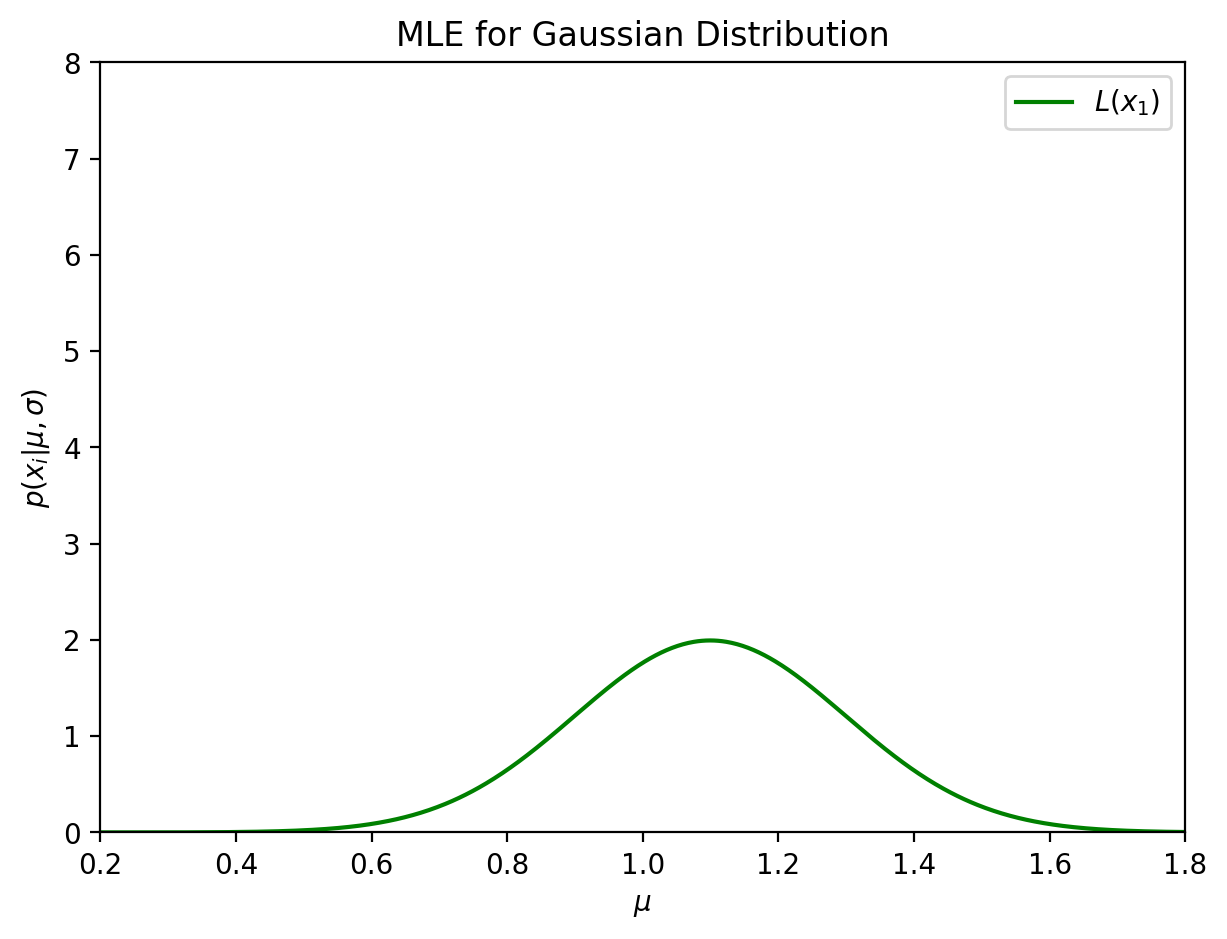

In [24]:
#Make the plot and see if you get the same as me.
xgrid = np.linspace(0,2,1000)
L1 = norm.pdf(xgrid,loc=sample[0],scale=sigma) #This is a Gaussian PDF sampled uniformly, centered at a specific location.
L2 = norm.pdf(xgrid,loc=sample[1],scale=sigma)
L3 = norm.pdf(xgrid,loc=sample[2],scale=sigma)
L = L1 * L2 * L3 #Total L is ???

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, L1, ls='-', c='green', label=r'$L(x_1)$')
#plt.plot(xgrid, L2, ls='-', c='red', label=r'$L(x_2)$')
#plt.plot(xgrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
#plt.plot(xgrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

Now we can just read off the maximum likelihood solution.  <font color='red'>Use `np.argsort()` to figure out the index of the largest value and print that element of `xgrid`.</font>

In [25]:
sorted_indices = np.argsort(L)
index_max = sorted_indices[-1]
print("Likelihood is maximized at %.3f" % xgrid[index_max])

Likelihood is maximized at 1.067


## Quantifying Estimate Uncertainty <a class="anchor" id="four"></a>

Our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the shape and distribution of the likelihood function, but we'd like to capture that with a few numbers.

The ***asymptotic normality of MLE*** is invoked to approximate the likelihood function as a Gaussian (or the $\ln L$ as a parabola), i.e. we take a Taylor expansion around the MLE, keep terms up $2^\mathrm{nd}$ order, then *define* the uncertainty on our model parameters as:

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

where

$$ F_{jk} = - \frac{\partial^2}{\partial\theta_j} \frac{\ln L}{\partial\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

The matrix $F$ is known as the **observed Fisher information matrix**. The elements $\sigma^2_{jk}$ are known as the ***covariance matrix***.

The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement. Off diagonal elements, $\sigma_{ij}$, arise from any correlation between the parameters in the model.

In our example of a homoscedastic Gaussian, the uncertainly on the mean is 

$$\sigma_{\mu} = \left( - \frac{\partial^2\ln L(\mu)}{\partial\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find

$$\frac{\partial^2\ln L(\mu)}{\partial\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$

since, again, $\sigma = {\rm constant}$.  

Then 

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you should be familiar with. 

Let's check this with a quick and dirty calculation. In the following, we 
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide through by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.

In [26]:
# Read, think about, and execute the following cell

sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.115


Let's plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution for the three data points above.

In [27]:
measured_mean = np.mean(sample)
print(measured_mean)

1.067075892662716


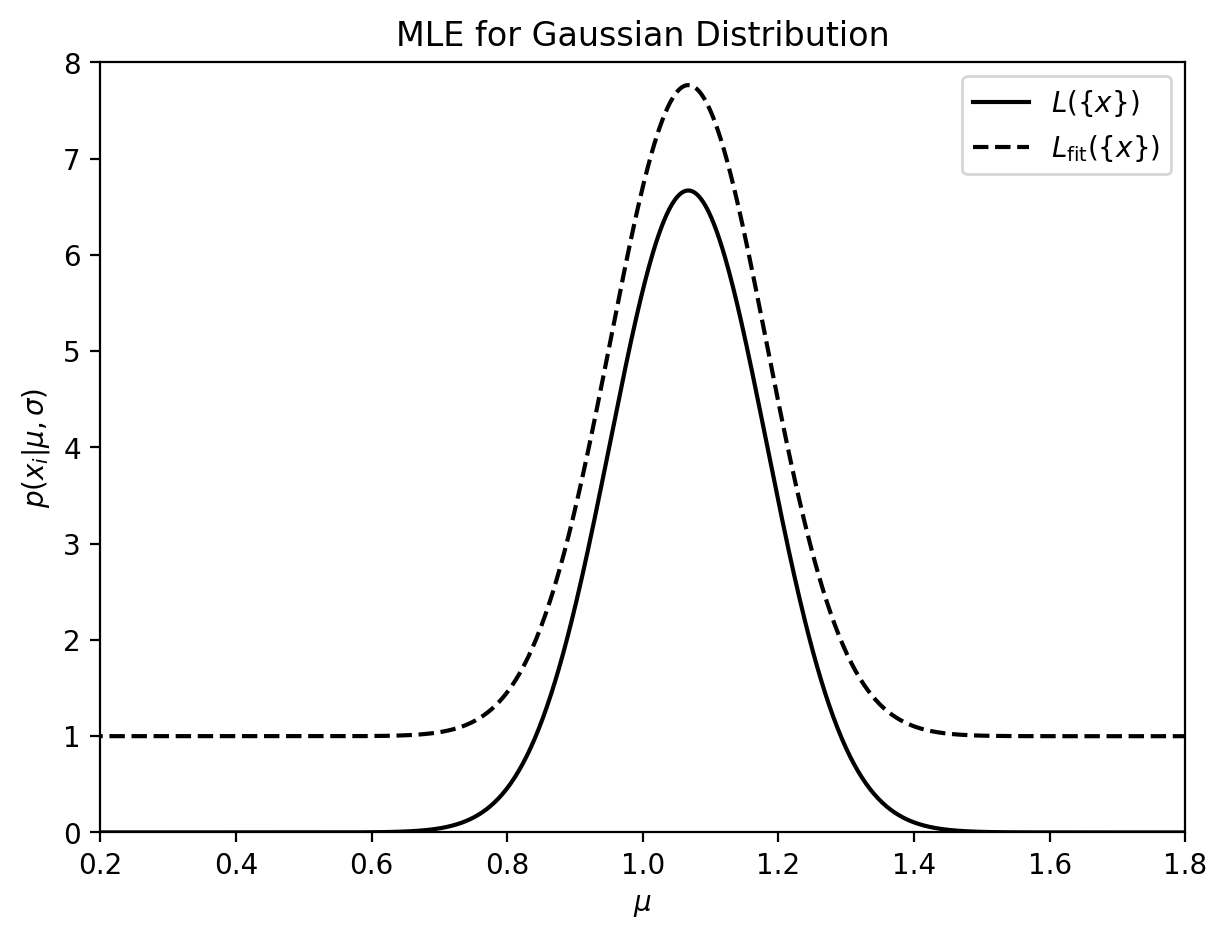

In [28]:
# Execute the following cell

xgrid = np.linspace(0.0,2.0,1000)
L = np.prod([L1,L2,L3],axis=0) # Total L is ???
# complete the following for measured mean and Fisher error
Lfit = norm.pdf(xgrid,loc=xgrid[index_max],scale=0.115)  

fig, ax = plt.subplots(figsize=(7, 5))

# plot numerical likelihood
plt.plot(xgrid, L, ls='-', c='black', 
         label=r'$L(\{x\})$')

# plot fitted Gaussian with arbitrary normalizing constant
# offset for ease of viewing
C = 1.95
plt.plot(xgrid, C * Lfit + 1.0, ls='dashed', 
         c='black', label=r'$L_\mathrm{fit}(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

Looks pretty, pretty, pretty good. ("Curb your enthusiasm" reference to see who is paying attention) 

But does this agree with the general homoescedastic sample mean uncertainty? <font color='red'>Compute $\sigma_\mu$ from one of the formulae above with $N=3$. Does it agree with the Fisher matrix error?</font>

In [31]:
N = 3
sigma = 0.2

sigma_mu = sigma / np.sqrt(N)

fisher_error = sigma / np.sqrt(N)

print("Fisher error: %.3f" % fisher_error)

if np.isclose(sigma_mu, fisher_error):
    print("The uncertainty in the sample mean agrees with the Fisher matrix error.")
else:
    print("The uncertainty in the sample mean does not agree with the Fisher matrix error.")


Fisher error: 0.115
The uncertainty in the sample mean agrees with the Fisher matrix error.


### What is $\pm \sigma$? Errors as Gaussian Approximations to the Likelihood Function

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor series and retaining terms up to second order (essentially, $\ln L$ is approximated by a parabola, or an ellipsoidal surface in multidimensional cases, around its maximum). If this expansion is exact (as is the case for a Gaussian error distribution), then we've completely captured the error information.

In general, this is not the case and the likelihood surface can significantly deviate from a smooth elliptical surface. Furthermore, it often happens in practice that the likelihood surface is multimodal. It is always a good idea to visualize the likelihood surface when in doubt (see examples in §5.6 in the textbook).

### What is $\pm \sigma$? Errors as Gaussian Approximations to the Likelihood Function

The $(\hat \mu - \sigma_\mu, \hat \mu + \sigma_\mu)$ range gives us a **confidence interval**.

In frequentist interptetation, if we repeated the same measurement a hundred times, we'd find for 68 experiments the true value was within their computed confidence intervals ($1 \sigma$ errors).

## MLE applied to a Heteroscedastic Gaussian <a class="anchor" id="five"></a>

Now let's look a case where the uncertainties are heteroscedastic.  For example if we are measuring the length of a rod and have $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement, $\sigma_i$ is known.  Since $\sigma$ is not a constant, then following the above, we have

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\hat \mu} = \sum_{i=1}^N \frac{(x_i - \hat \mu)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\hat \mu}{\sigma_i^2},$$

yields a MLE solution of 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$




## Working with non-Gaussian Likelihoods <a class="anchor" id="six"></a>

As an example of MLE with non-Gaussian probability density we can use the same formalism above for a Poisson distribution. In this case we write the probability disrtibution as

$$p(x_i|\mu) = \frac{e^{-\mu}\mu^{x_i}}{x_i!}$$

with $\mu$ the average number of events, $N$ is the number of observed events, and $\{x_i\}$ are the measured data.

As we saw before, this distribution is particularly useful for characterizing the number of soldiers in the Prussian army killed accidentally by horse kicks.

We can then write the likelihood as

$$L \equiv p(\{x_i\}|\mu) = \prod_{i=1}^{N} \frac{e^{-\mu}\mu^{x_i}}{x_i!}$$

and the $\ln L$ as

$$\ln L = \sum_{i=1}^{N} \ln \bigg( \frac{e^{-\mu}\mu^{x_i}}{x_i!} \bigg)$$

$$= \sum_{i=1}^{N} -\mu + x_i \; \ln(\mu) - \ln({x_i!})$$

In [30]:
# Install seaborn.
# This package can make matplotlib prettier
pip install seaborn

SyntaxError: invalid syntax (963861855.py, line 3)

In [ ]:
# Execute this cell to plot some Poisson draws from different means
from scipy.stats import poisson
import seaborn as sns

# generate samples for different values of mu
kpts=np.arange(0,25)
for mu, c in zip([1,3,12], 
                 sns.color_palette()[:4]):
    # random draws
    randomVariates = poisson.rvs(mu, size=1000)
    # histogram of random draws
    plt.hist(randomVariates, density=True, color=c, alpha=0.2, 
             bins=range(0,26), label='$\mu=' + np.str(mu) + '$')
    # probability density at bin locations
    plt.plot(kpts, poisson.pmf(kpts, mu), '.', color=c)
    
plt.legend()
plt.title("Poisson Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Normed Counts");

<font color='red'>Complete and execute the following cell to generate $5$ random samples from a $\mu=12$ Poisson distribution and find the MLE $\hat\mu$ from the data.</font>

In [ ]:
poisson_data = poisson.rvs(12, size=5)

# Scan across 1000 possible mu values from 3 to 20.
mu_proposed = np.linspace(___,___,___)

# compute the lnL for each possible mu.
lnL_scan = []
for mu in mu_proposed:
    lnL_temp = poisson.logpmf(poisson_data, mu=___) # gives you the log prob. density; useful!
    lnL_temp = ___.___(___) # sum over the log pmf of all data points
    lnL_scan.append( lnL_temp )
    
# convert to numpy array
lnL_scan = np.array(lnL_scan)

# write some quick code below to find the element of 
# mu_proposed that maximizes the lnL.

<font color='red'>Plot lnL vs mu_proposed and indicate where it is maximized.</font>

### Maximizing the $\ln L$ 

For the Poisson distribution we can solve for the maximum liklehood analytically

$$\frac{\partial \; L(\mu)}{\partial \; \mu} = \frac{\partial \; }{\partial \; \mu} \bigg( \sum_{i=1}^{N} -\mu + x_i \; \ln(\mu)\bigg)$$

$$0 = \sum_{i=1}^{N} \bigg( -1 + \frac{x_i}{\mu} \bigg)$$
$$\hat\mu = \frac{1}{N} \sum_{i=1}^{N} x_i $$

What do you know!? The same as for a homoescedastic Gaussian! 

***For many likelihoods we cannot solve for the maximum analytically, and we have to resort to numerical solutions.*** We'll treat these in detail later using MCMC and robust statistics that account for outliers.

<font color='red'>Use this formula to compute $\hat\mu$ for your `poisson_data` above. Does it agree with your numerical estimate?</font>

## Summary

Today we heard about:

* Classical vs. Bayesian Inference (more next week)
* Likelihood function
* Maximum Likelihood Estimation
  * Homoscedastic Samples
  * Heteroscedastic Samples
* Quantifying uncertainty on ML estimates
* Working with non-Gaussian likelihoods